# Session 1 - Linear Regression

## Contents

- [Load Datasets](#Load-Datasets)
- [Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)
- [Collineariry](#Collinearity)
- [Session 2 - Instrumental Variables](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/2_iv.ipynb)

In [1]:
# Import numpy for math
import numpy as np

# Iport pandas for data
import pandas as pd

# Import matplotlib and seaborn for grephs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')

## Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
# Advertisement spending data
advertising = pd.read_csv('data/Advertising.csv', usecols=[1,2,3,4])

How do we inspect a dataset in python?
1. the `info` function for an overview of all varaibles
2. the `head` function for a glimpse of the actual data

In [3]:
# 1. Overview of all variables
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [4]:
# Credit ratings dataset
credit = pd.read_csv('data/Credit.csv', usecols=list(range(1,12)))

In [5]:
# 2. Preview of the data
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


You can also select the number of rows you want to show

In [6]:
# Automobile dataset
auto = pd.read_csv('data/Auto.csv', na_values='?').dropna()
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite


## 3.1 Simple Linear Regression

Suppose we are interested in the (linear) relationship between sales and tv advertisement.

$$
sales ≈ \beta_0 + \beta_1 TV.
$$

How are the two two variables related? Visual inspection: scatterplot.

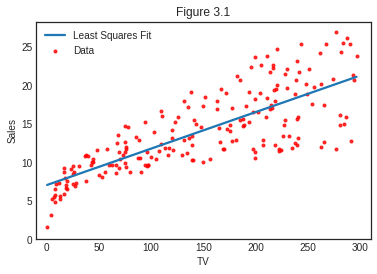

In [7]:
# Figure 3.1 - Least squares fit
sns.regplot(x=advertising.TV, y=advertising.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310); plt.ylim(ymin=0)
plt.legend(['Least Squares Fit','Data'])
plt.title('Figure 3.1');

### 3.1.1 Estimating the Coefficients

How do we estimate the best fit line? Minimize the Residual Sum of Squares (RSS).

First, we define the prediction of $y$ based on $X$ as

$$
\hat y_i = \hat \beta x_i
$$

The residuals are the unexplained component of $y$

$$
e_i = y_i - \hat y_i
$$

Our objective function (to be minimized) is the Resdual Sum of Squares (RSS):

$$
RSS := \sum_{n=1}^N e_i^2
$$

And the OLS coefficient is defined as its minimizer:

$$
\hat \beta_{OLS} := \arg\min_{\beta} \sum_{n=1}^N e_i^2 = \arg\min_{\beta} \sum_{n=1}^N (y_i - x_i \beta)^2
$$

In [8]:
import sklearn.linear_model as skl_lm

# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

# Define X and y
X = advertising.TV.values.reshape(-1,1)
y = advertising.Sales.values

# Fit linear regressions
regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

7.032593549127695
[0.04753664]


We can visualize the residuals as the vertical distances between the data and the prediction line. The objective function RSS is the sum of the squares of the lengths of vertical lines.

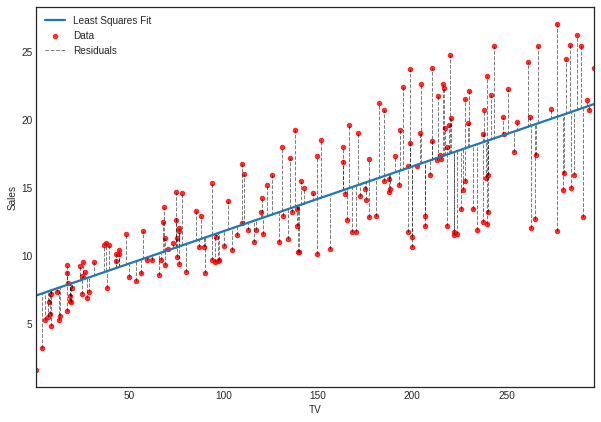

In [9]:
# Compute predicted values
y_hat = regr.predict(X)

# Plotting the regression line
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.regplot(x=advertising.TV, y=advertising.Sales, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':20})
ax.vlines(X, np.minimum(y,y_hat), np.maximum(y,y_hat), linestyle='--', color='k', alpha=0.5, linewidth=1)
plt.legend(['Least Squares Fit','Data','Residuals']);

The closed form solution in matrix algebra is
$$
\hat \beta_{OLS} = (X'X)^{-1}(X'y)
$$

The syntax in python is particularly verbose. In Matlab it would be `(X'*X)^{-1}*(X'*y)`, almost literal.

In [10]:
from numpy.linalg import inv

# Compute OLS coefficient with matrix algebra
beta = inv(X.T @ X) @ X.T @ y

print(beta)

[0.08324961]


Why is the result different?

We are missing one coefficient: the intercept. Our regression now looks like this

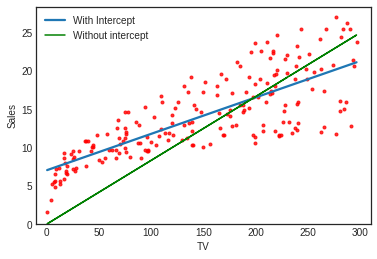

In [11]:
# Add new line on the previous plot
fig, ax = plt.subplots()
sns.regplot(x=advertising.TV, y=advertising.Sales, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':9})
ax.plot(X, beta*X, color='g')
plt.xlim(-10,310); plt.ylim(ymin=0);
ax.legend(['With Intercept', 'Without intercept']);

How do we insert an intercept using matrix algebra? We add a column of ones.

$$
X_1 = [\boldsymbol{1}, X]
$$

In [12]:
# How to insert intercept? Add constant: column of ones
one = np.ones(np.shape(X))
X1 = np.concatenate([one,X],axis=1)

print(np.shape(X1))

(200, 2)


Now we compute again the coefficients as before.

$$
\hat \beta_{OLS} = (X_1'X_1)^{-1}(X_1'y)
$$

In [13]:
# Compute beta OLS with intercept
beta_OLS = inv(X1.T @ X1) @ X1.T @ y

print(beta_OLS)

[7.03259355 0.04753664]


Now we have indeed obtained the same exact coefficients.

What does minimizing the Residual Sum of Squares means in practice? How does the objective function looks like?

In [14]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y)**2)/1000
min_rss

1746.35338337373

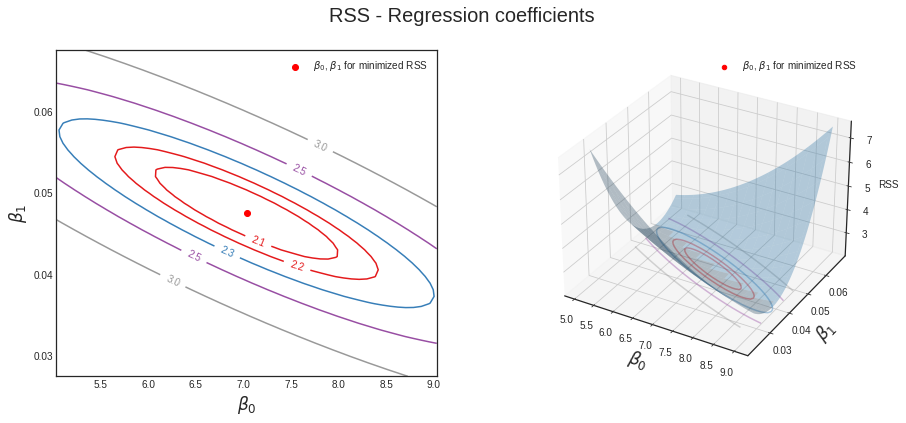

In [15]:
# Figure 3.2 - Regression coefficients - RSS
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

Why does it look different from the figure in the book? In the book they standardazed the X variable so that the contour sets are circular and not ellyptical.

### 3.1.2 Assessing the Accuracy of the Coefficient Estimates

How accurate is our regression fit? Suppose we were drawing different (small) samples from the same data generating process, for example

$$
y_i = 2 + 3x_i + \varepsilon_i
$$

where $x_i \sim N(0,1)$ and $\varepsilon \sim N(0,3)$.

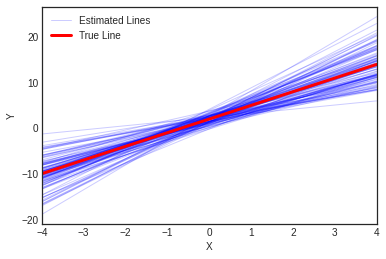

In [16]:
fig, ax = plt.subplots()
x = np.linspace(-4,4,30)

# Init
N = 30;
K = 100;
beta_hat = np.zeros((2,K))

# K simulations
for i in range(K):
    # Simulate data
    x1 = np.random.normal(0,1,N).reshape([-1,1])
    X = np.concatenate([np.ones(np.shape(x1)), x1], axis=1)
    epsilon = np.random.normal(0,5,N)
    beta0 = [2,3]
    y = X @ beta0 + epsilon

    # Estimate coefficients
    beta_hat[:,i] = inv(X.T @ X) @ X.T @ y

    # Plot line
    ax.plot(x, beta_hat[0,i] + x*beta_hat[1,i], color='blue', alpha=0.2, linewidth=1)
    if i==K-1:
        ax.plot(x, beta_hat[0,i] + x*beta_hat[1,i], color='blue', alpha=0.2, linewidth=1, label='Estimated Lines')
    
# Plot true line
ax.plot(x, 2 + 3*x, color='red', linewidth=3, label='True Line');
ax.legend()
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_xlim(-4,4);

As we can see, depending on the sample, we get a different estimate of the linear relationship between $x$ and $y$. However, there estimates are on average correct. Indeed, we can visualize their distribution.

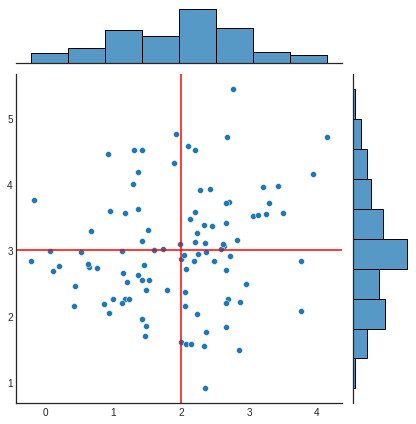

In [17]:
# Plot distribution of coefficients
plot = sns.jointplot(x=beta_hat[0,:], y=beta_hat[1,:], edgecolor="white");
plot.ax_joint.axvline(x=2, color='red');
plot.ax_joint.axhline(y=3, color='red');

How do we compute confidence intervals by hand?

$$
Var(\hat \beta_{OLS}) = \sigma^2 (X'X)^{-1}
$$

where $\sigma^2 = Var(\varepsilon)$. Since we do not know $Var(\varepsilon)$, we estimate it as $Var(e)$.

$$
\hat Var(\hat \beta_{OLS}) = \hat \sigma^2 (X'X)^{-1}
$$

If we assume the standard errors are normally distributed (or we apply the Central Limit Theorem, assuming $n \to \infty$), a 95% confidence interval for the OLS coefficient takes the form

$$
CI(\hat \beta_{OLS}) = \Big[ \hat \beta_{OLS} - 1.96 \times \hat SE(\hat \beta_{OLS}) \ , \ \hat \beta_{OLS} + 1.96 \times \hat SE(\hat \beta_{OLS}) \Big]
$$

where $\hat SE(\hat \beta_{OLS}) = \sqrt{\hat Var(\hat \beta_{OLS})}$.

In [18]:
# Import again X and y from example above
X = advertising.TV.values.reshape(-1,1)
X1 = np.concatenate([np.ones(np.shape(X)), X], axis=1)
y = advertising.Sales.values

# Compute residual variance
X_hat = X1 @ beta_OLS
e = y - X_hat
sigma = np.var(e)
var_beta_OLS = sigma * inv(X1.T @ X1)

# Take elements on the diagonal and square them
std_beta_OLS = [var_beta_OLS[0,0]**.5, var_beta_OLS[1,1]**.5]

print(std_beta_OLS)

[0.4555479737400674, 0.0026771203500466564]


The `statsmodels` library allows us to produce nice tables with parameter estimates and standard errors.

In [19]:
# Table 3.1 & 3.2
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Compact version with confidence intervals
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


### 3.1.3 Assessing the Accuracy of the Model

What metrics can we use to assess whether the model is a good model, in terms of captureing the relationship between the variables?

First, we can compute our objective function: the Residual Sum of Squares (RSS).

In [20]:
# RSS with regression coefficients
RSS = sum(e**2)

print(RSS)

2102.5305831313512


Alternatively, we can compute $R^2$: the percentage of our explanatory variable explained by the model

$$
R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}
$$

where

$$
TSS = \sum_{i=1}^N (y_i - \bar y)^2
$$

In [21]:
# TSS
TSS = sum( (y-np.mean(y))**2 )

# R2
R2 = 1 - RSS/TSS

print(R2)

0.6118750508500708


Can the $R^2$ metric be negative? When?

## 3.2 Multiple Linear Regression

What if we have more than one explanatory variable?

In [22]:
# Table 3.3 (1)
est = smf.ols('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [23]:
# Table 3.3 (2)
est = smf.ols('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


It seems that both Radio and Newspapers are positively correlated with Sales. 

### 3.2.1 Estimating the Regression Coefficients

In [24]:
# Table 3.4 & 3.6
est = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 24 Sep 2020   Prob (F-statistic):           1.58e-96
Time:                        18:08:56   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Why now it seems that there is no relationship between Sales and Newspaper while the univariate regression told us the opposite?

Let's explore the correlation between those variables.

In [25]:
# Table 3.5 - Correlation Matrix
advertising.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


Let's try to visualize the relationship visually. Note that now the linear best fir is going to be a plane instead of a line.

In [26]:
regr = skl_lm.LinearRegression()

X = advertising[['Radio', 'TV']]
y = advertising.Sales

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.9210999124051398


In [27]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['Radio', 'TV']].describe()

,Radio,TV
count,200.000000,200.000000
mean,23.264000,147.042500
std,14.846809,85.854236
min,0.000000,0.700000
25%,9.975000,74.375000
50%,22.900000,149.750000
75%,36.525000,218.825000
max,49.600000,296.400000


In [28]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

In [29]:
# Residuals
e = y - regr.predict(X)

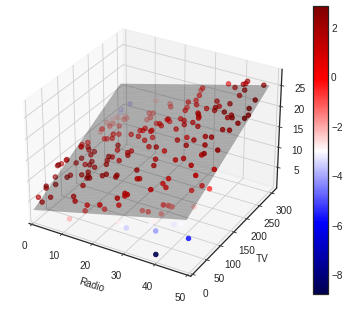

In [30]:
# Figure 3.5 - Multiple Linear Regression
fig = plt.figure(figsize=(5,4))
ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, color='k', alpha=0.3)
points = ax.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c=e, cmap="seismic")
plt.colorbar(points)

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(bottom=0)
ax.set_zlabel('Sales');

## 3.3 Other Considerations in the Regression Model

#### 3.3.1 Qualitative Predictors

What if some variables are qualitative instead of quantitative? For example, in the credit rating dataset, we have the varaible `Student`.

In [31]:
# What values does the Student variable take?
credit['Student'].unique()

array(['No', 'Yes'], dtype=object)

We can convert it into a binary variable.

In [32]:
# Convert 'Student' to be a binary variable
credit['Student'] = credit.Student.map({'No':0, 'Yes':1})
credit['Student'].unique()

array([0, 1])

There are many such variables in the data.

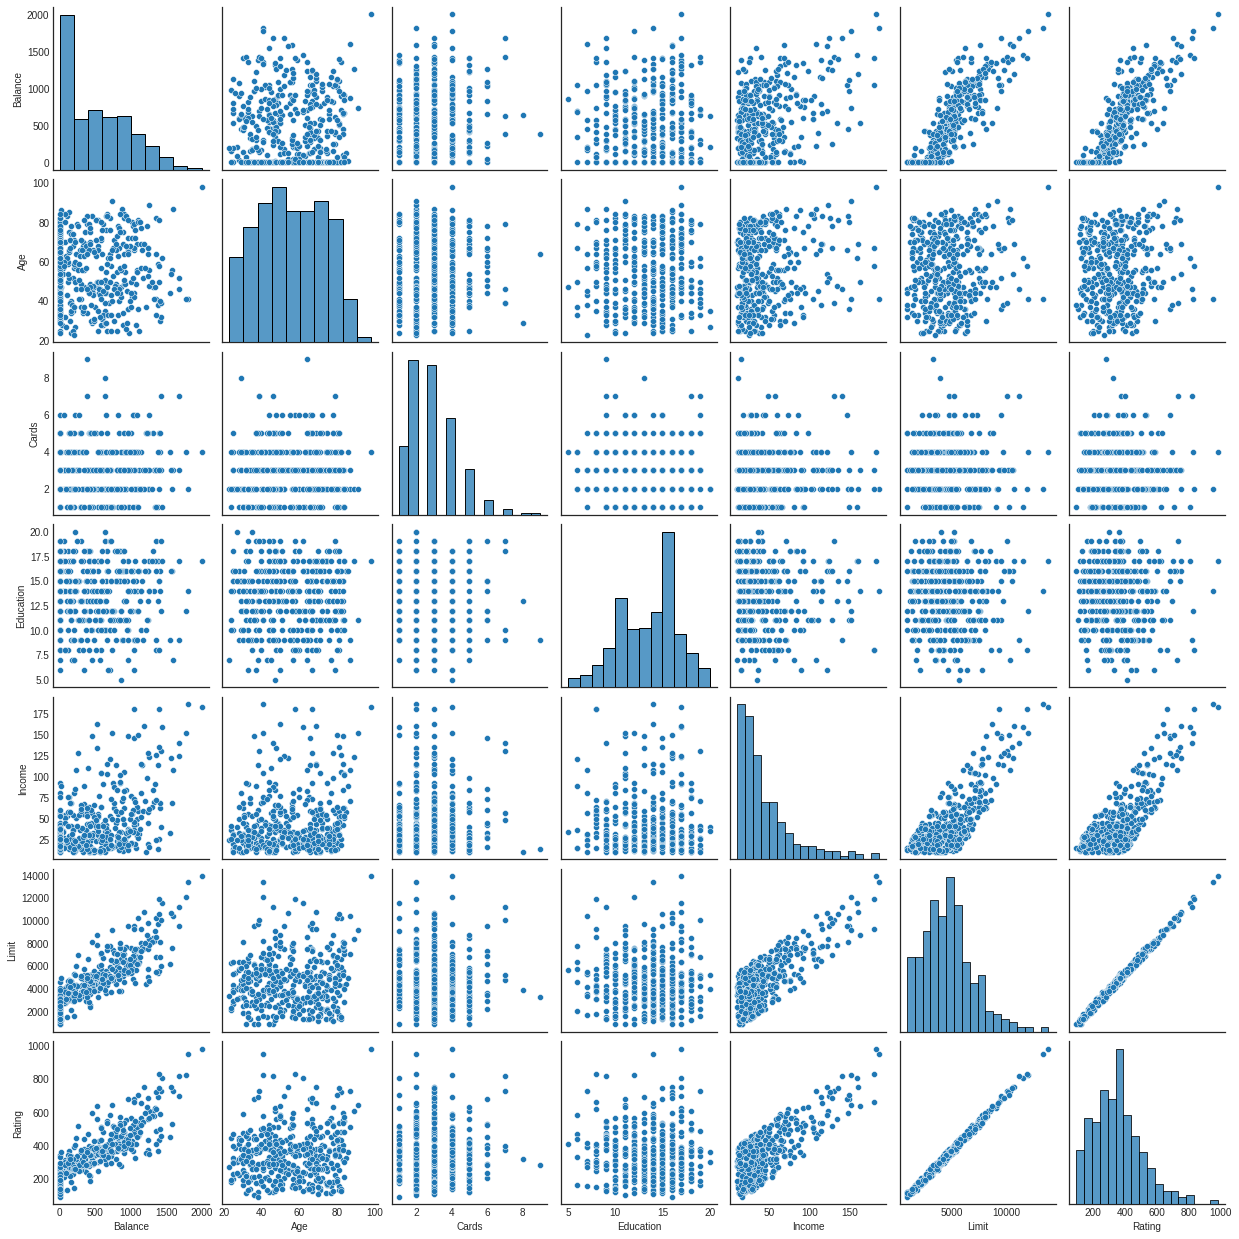

In [33]:
# Figure 3.6
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

What happens if you pass a binary varaible to `statsmodel`? It automatically generates a dummy out of it.

In [34]:
# Table 3.7
est = smf.ols('Balance ~ Gender', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,509.8031,33.128,15.389,0.000,444.675,574.931
Gender[T.Female],19.7331,46.051,0.429,0.669,-70.801,110.267


If a variable takes more than one value, `statsmodel` automatically generates a uniqe dummy for each level (-1).

In [35]:
# Table 3.8
est = smf.ols('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


### 3.3.2 Extensions of the Linear Model

We have seen that both TV and Radio advertisement are positively associated with Sales. What if there is a synergy?

Consider the following model

$$
\text{Sales} ≈ \beta_0 + \beta_1 \text{TV} + \beta_2 \text{Radio} + \beta_3 \text{TV} \times \text{Radio}
$$

In [36]:
# Table 3.9 - Interaction Variables
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


We can do interactions with qualitative variables as well. Conside the credit rating dataset. What if balance depends by income and the fact that you are a student but also depends by income differently, depending on whether one is a student or not?

In this case, the model is

$$
\text{Balance} ≈ \beta_0 + \beta_1 \text{Income} + \beta_2 \text{Student} + \beta_3 \text{Income} \times \text{Student}
$$

In [37]:
# Figure 3.7 - Interaction between qualitative and quantative variables
est1 = smf.ols('Balance ~ Income + Student', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student      382.670539
dtype: float64

Regression 2 - with interaction term
Intercept         200.623153
Income              6.218169
Student           476.675843
Income:Student     -1.999151
dtype: float64


Without the interaction term, the two lines have different levels but the same slope. Introducing an interaction term allows the two groups to have different responses to Income.

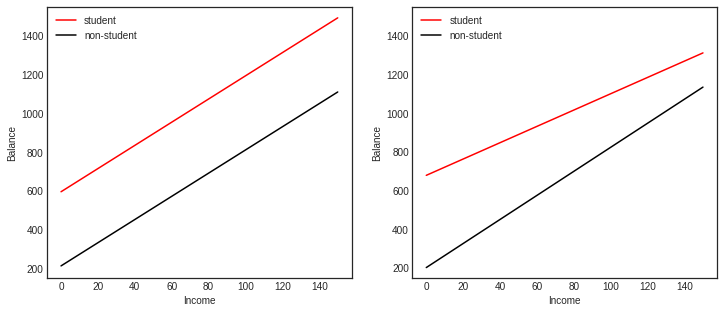

In [38]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student'],
                       regr1['Intercept']+regr1['Student']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student'],
                       regr2['Intercept']+regr2['Student']+
                       150*(regr2['Income']+regr2['Income:Student']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

What if we allow for further non-linearities?

Take the car dataset adn consider the relationship between efficiency (mpg: miles per gallon) and horsepower. It might be  highly non-linear relationship.

$$
\text{mpg} ≈ \beta_0 + \beta_1 \text{horsepower} + + \beta_2 \text{horsepower}^2 + ... ???
$$

How many terms should we include?

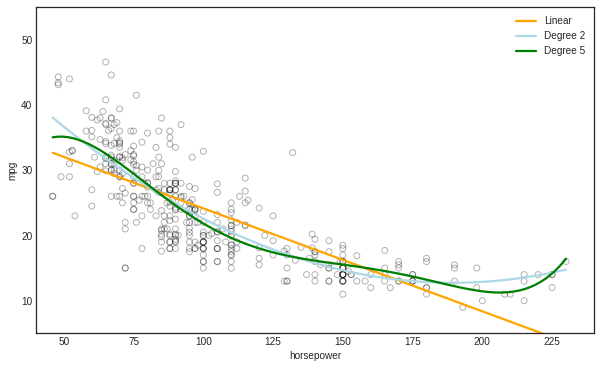

In [39]:
# Figure 3.8 - Non-linear relationships
fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.scatter(x=auto.horsepower, y=auto.mpg, facecolors='None', edgecolors='k', alpha=.3) 
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

As we can see, the tails are highly unstable depending on the specification.

In [40]:
# Table 3.10
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,horsepower2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,16900.0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,27225.0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,22500.0


In [41]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


How can we assess which one is better? Look at the residuals.

In [42]:
# Figure 3.9
regr = skl_lm.LinearRegression()

# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']]
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

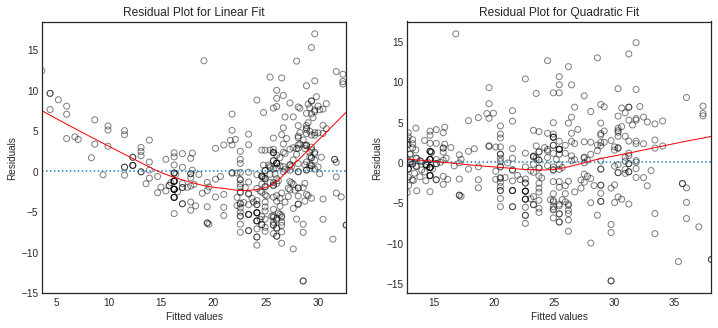

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(x=auto.pred1, y=auto.resid1, lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(x=auto.pred2, y=auto.resid2, lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2,
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

Observations with high residuals have a good chance of being highly influentials. However, do not have to be.

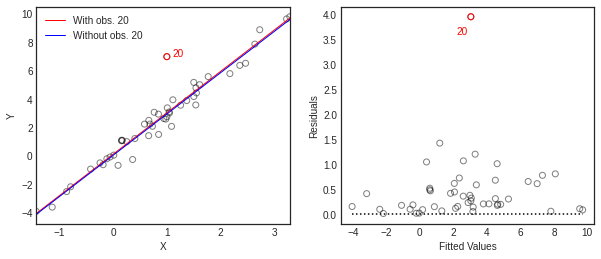

In [44]:
# Figure 3.12
from numpy.random import normal as rnorm
from numpy.random import seed
seed(2)

# Generate random y
n = 50
X = rnorm(1,1,(n,1))
e = rnorm(0,0.5,(n,1))
b0 = 3
y = X*b0 + e

# Generate outlier
X[20] = 1
y[20] = 7

# Short regression without observation number 41
X_small = np.delete(X, 20)
y_small = np.delete(y, 20)

# Plot 1
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4)) 
ax1.scatter(x=X, y=y, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(x=X, y=y, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'r', 'lw':1})
sns.regplot(x=X_small, y=y_small, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'b', 'lw':1})
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); 
ax1.legend(['With obs. 20', 'Without obs. 20']);
# Hihglight outliers
ax1.scatter(x=X[20], y=y[20], facecolors='None', edgecolors='r', alpha=1) 
ax1.annotate("20", (1.1, 7), color='r')

# Compute fitted values and residuals
r = regr.fit(X, y)
y_hat = r.predict(X)
e = np.abs(y - y_hat)

# Plot 2
ax2.scatter(x=y_hat, y=e, facecolors='None', edgecolors='k', alpha=.5)
ax2.set_xlabel('Fitted Values'); ax2.set_ylabel('Residuals');
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted',color='k')
# Highlight outlier
ax2.scatter(x=y_hat[20], y=e[20], facecolors='None', edgecolors='r', alpha=1) 
ax2.annotate("20", (2.2, 3.6), color='r');

A better concept of "influential observation" is the Leverage, which represents how much an observation is distant from the others in terms of observables.

The leverage formula of observation $i$ is

$$
h_i = x_i (X' X)^{-1} x_i'
$$

However, leverage alone is not necessarily enough for an observation to being highly influential.

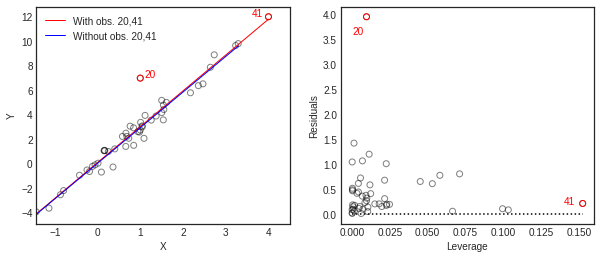

In [45]:
# Fig 3.13

# Generate other outlier
X[41] = 4
y[41] = 12

# Short regression without observation number 41
X_small = np.delete(X_small, 41)
y_small = np.delete(y_small, 41)

# Plot 1
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4)) 
ax1.scatter(x=X, y=y, facecolors='None', edgecolors='k', alpha=.5) 
ax1.scatter(x=X[[20,41]], y=y[[20,41]], facecolors='None', edgecolors='r', alpha=1) 
sns.regplot(x=X, y=y, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'r', 'lw':1})
sns.regplot(x=X_small, y=y_small, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'b', 'lw':1})
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.axis(xmax=4.5);
ax1.legend(['With obs. 20,41', 'Without obs. 20,41']);

# Highlight points
ax1.annotate("20", (1.1, 7), color='r')
ax1.annotate("41", (3.6, 12), color='r');

# Compute leverage
H = X @ inv(X.T @ X) @ X.T
h = np.diagonal(H)

# Compute fitted values and residuals
y_hat = r.predict(X)
e = np.abs(y - y_hat) 

# Plot 2
ax2.scatter(x=h, y=e, facecolors='None', edgecolors='k', alpha=.5)
ax2.set_xlabel('Leverage'); ax2.set_ylabel('Residuals'); 
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted',color='k')
# Highlight outlier
ax2.scatter(x=h[[20,41]], y=e[[20,41]], facecolors='None', edgecolors='r', alpha=1);

# Highlight points
ax2.annotate("20", (0, 3.6), color='r')
ax2.annotate("41", (0.14, 0.2), color='r');

What really matters is a combination of both: observations with high leverage and high residuals, i.e. observations that are not only different in terms of observables (high leverage) but are also different in terms of their relationship between observables and dependent variable (high residual).

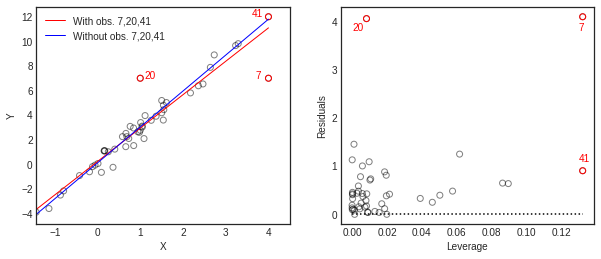

In [46]:
# Generate other outlier
X[7] = 4
y[7] = 7

# Short regression without observation number 41
X_small = np.delete(X, 7)
y_small = np.delete(y, 7)

# Plot 1
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4)) 
ax1.scatter(x=X, y=y, facecolors='None', edgecolors='k', alpha=.5) 
ax1.scatter(x=X[[7,20,41]], y=y[[7,20,41]], facecolors='None', edgecolors='r', alpha=1) 
sns.regplot(x=X, y=y, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'r', 'lw':1})
sns.regplot(x=X_small, y=y_small, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'b', 'lw':1})
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.axis(xmax=4.5);
ax1.legend(['With obs. 7,20,41', 'Without obs. 7,20,41']);

# Highlight points
ax1.annotate("7", (3.7, 7), color='r')
ax1.annotate("20", (1.1, 7), color='r')
ax1.annotate("41", (3.6, 12), color='r');

# Compute leverage
H = X @ inv(X.T @ X) @ X.T
h = np.diagonal(H)

# Compute fitted values and residuals
r = regr.fit(X, y)
y_hat = r.predict(X)
e = np.abs(y - y_hat)

# Plot 2
ax2.scatter(x=h, y=e, facecolors='None', edgecolors='k', alpha=.5)
ax2.set_xlabel('Leverage'); ax2.set_ylabel('Residuals'); 
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted',color='k')
# Highlight outlier
ax2.scatter(x=h[[7,20,41]], y=e[[7,20,41]], facecolors='None', edgecolors='r', alpha=1);

# Highlight points
ax2.annotate("7", (0.13, 3.8), color='r');
ax2.annotate("20", (0, 3.8), color='r')
ax2.annotate("41", (0.13, 1.1), color='r');

## Collinearity

Collinearity is the situation in which two dependent varaibles are higly correlated with each other. Algebraically, this is a problem because the $X'X$ matrix becomes almost-non-invertible.

An example is `Rating` and `Limit` in the credit ratings dataset.

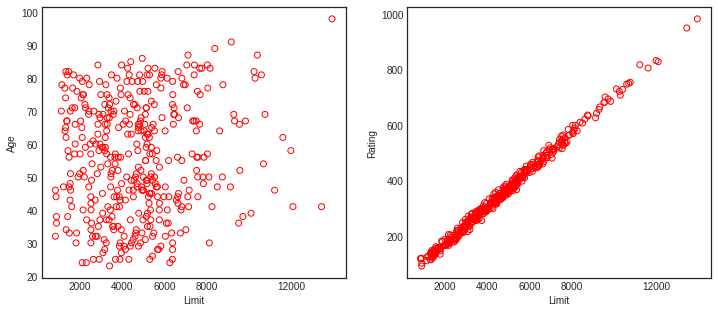

In [47]:
# Figure 3.14
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.scatter(credit.Limit, credit.Age, facecolor='None', edgecolor='r')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit.Limit, credit.Rating, facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

Looking at the objective function, RSS, helps understanding what is the problem.

In [48]:
from sklearn.preprocessing import scale

y = credit.Balance

# Regression for left plot
X = credit[['Age', 'Limit']]
regr1 = skl_lm.LinearRegression()
regr1.fit(scale(X.astype('float'), with_std=False), y)
print('Age/Limit\n',regr1.intercept_)
print(regr1.coef_)

# Regression for right plot
X2 = credit[['Rating', 'Limit']]
regr2 = skl_lm.LinearRegression()
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('\nRating/Limit\n',regr2.intercept_)
print(regr2.coef_)

Age/Limit
 520.0150000000001
[-2.29148553  0.17336497]

Rating/Limit
 520.015
[2.20167217 0.02451438]


In [49]:
# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.Limit.astype('float'), with_std=False)
Age_scaled = scale(credit.Age.astype('float'), with_std=False)
Rating_scaled = scale(credit.Rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled +
                    Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled +
                    Y2[i,j]*Rating_scaled))**2).sum()/1000000

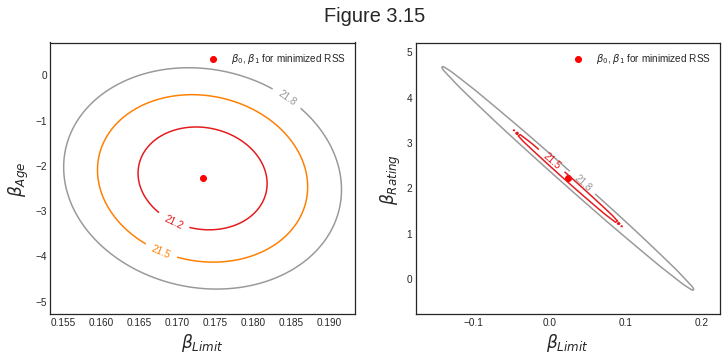

In [50]:
# Figure 3.15
fig = plt.figure(figsize=(12,5))
fig.suptitle('Figure 3.15', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(regr1.coef_[1], regr1.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=17)

# Right plot
CS = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
ax2.scatter(regr2.coef_[1], regr2.coef_[0], c='r', label=min_RSS)
ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=17)
ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r'$\beta_{Limit}$', fontsize=17)
    ax.legend()

As we can see, in the left plot the minimum is much better defined than in the right plot.

### Variance Inflation Factor - page 102

In [54]:
# Table 3.11 (1)
est_Age = smf.ols('Balance ~ Rating + Limit', credit).fit()
est_Age.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-377.5368,45.254,-8.343,0.000,-466.505,-288.569
Rating,2.2017,0.952,2.312,0.021,0.330,4.074
Limit,0.0245,0.064,0.384,0.701,-0.101,0.150


In [55]:
# Table 3.11 (2)
est_Rating = smf.ols('Balance ~ Age + Limit', credit).fit()
est_Rating.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-173.4109,43.828,-3.957,0.000,-259.576,-87.246
Age,-2.2915,0.672,-3.407,0.001,-3.614,-0.969
Limit,0.1734,0.005,34.496,0.000,0.163,0.183


## Next Lecture

Jump to [Session 2 - Instrumental Variables](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/2_iv.ipynb)